In [1]:
import pandas as pd
from numpy import nan
import numpy as np
import matplotlib.pyplot as plt

import constant
from myplot import geo_precentage, roughness_simulation

# Load data

In [2]:
dtype = {"GSRN":str,"Parent_GSRN":str,"Turbine_type":str,"BBR_municipal":str,"Placement":str,"grid":str}
windmills = pd.read_csv("./data/windmill_cleaned.csv", dtype=dtype)
# dfAgg = pd.read_parquet("./data/dfAgg.parquet")[["GSRN", "Placement", "ws10", "ws100"]]

In [3]:
len(windmills)

3576

In [4]:
windmills["Slope"] = round(windmills["Slope"], 0)
windmills["Aspect"] = round(windmills["Aspect"], 0)

In [5]:
windmill_SL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="W"]
windmill_SH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="W"]
windmill_PL = windmills[windmills["Placement"]=="LAND"][windmills["Turbine_type"]=="P"]
windmill_PH = windmills[windmills["Placement"]=="HAV"][windmills["Turbine_type"]=="P"]

In [6]:
print(len(windmill_SL))
print(len(windmill_SH))
print(len(windmill_PL))
print(len(windmill_PH))

3049
16
229
13


# The proportion of windmills under geo information
Roughness, Slope, Aspect

In [7]:
def geo_table(geofeature, percentage=True, sumed=False):
    type_place = {"PH" : windmill_PH ,"SH": windmill_SH, "PL":windmill_PL, "SL":windmill_SL}
    rt = pd.DataFrame(np.unique(windmills[geofeature]), columns=[geofeature]) 
    geo_count = lambda df, name: df.groupby(geofeature, as_index=False)["GSRN"].count().rename({"GSRN":name}, axis=1)
    for n, df in type_place.items():
        tmp = geo_count(df, n)
        tmp[n] = round(tmp[n] / len(df) * 100, 2) if percentage else tmp[n]
        rt = pd.merge(tmp, rt, on=geofeature, how="right")
    rt = rt.fillna(0)
    rt = rt.sort_values([geofeature]).reset_index(drop=True)

    cols = [x for x in rt.columns if x != geofeature]
    rt = rt.T
    headers = rt.iloc[0]
    rt  = pd.DataFrame(rt.values[1:], columns=headers)
    rt["type_place"] = cols
    rt = rt.set_index("type_place")
    
    if sumed:
        rt.loc[:,"sum"] = rt.sum(axis=1)
        rt.loc['sum',:]= rt.sum(axis=0)

    rt = rt if percentage else rt.astype(int)

    return rt

In [8]:
rn_count = geo_table("Roughness", False, True)
rn_count

Roughness,1e-06,0.0003,0.0005,0.005,0.03,0.05,0.1,0.3,0.5,0.6,sum
type_place,,,,,,,,,,,
SL,14,4,7,2836,22,6,31,89,10,30,3049
PL,2,0,1,212,2,0,5,5,1,1,229
SH,14,0,0,0,0,0,2,0,0,0,16
PH,13,0,0,0,0,0,0,0,0,0,13
sum,43,4,8,3048,24,6,38,94,11,31,3307


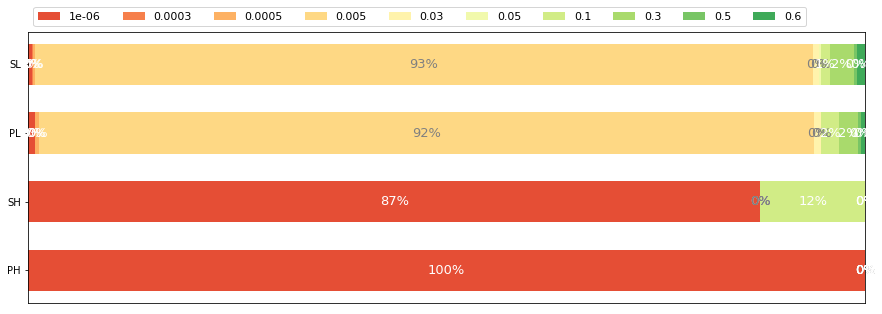

In [9]:
rn_count = geo_table("Roughness")
geo_precentage(rn_count, rn_count.columns, path=constant.plot_path+"geoanalysis/geo_precentage_roughness.png")

In [10]:
slope_count = geo_table("Slope", False, True)
slope_count

Slope,0.0,1.0,2.0,3.0,4.0,5.0,6.0,7.0,8.0,9.0,10.0,11.0,12.0,13.0,15.0,sum
type_place,,,,,,,,,,,,,,,,
SL,1221,549,381,627,125,69,42,10,15,5,1,1,1,1,1,3049
PL,98,46,24,39,6,10,4,0,1,1,0,0,0,0,0,229
SH,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,16
PH,13,0,0,0,0,0,0,0,0,0,0,0,0,0,0,13
sum,1347,595,406,666,131,79,46,10,16,6,1,1,1,1,1,3307


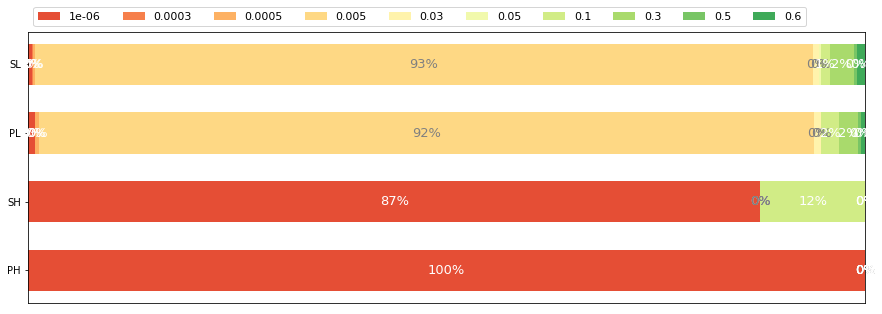

In [11]:
slope_count = geo_table("Roughness")
geo_precentage(slope_count, slope_count.columns, path=constant.plot_path+"geoanalysis/geo_precentage_slope.png")

In [12]:
aspect_count = geo_table("Aspect", False, True)
cols = [x for x in aspect_count.columns if x not in [-1.0, 0.0]]
aspect_count["others"] = aspect_count.apply(lambda x: sum(x[cols]), axis=1)

In [13]:
aspect_count

Aspect,-1.0,0.0,5.0,6.0,8.0,9.0,11.0,14.0,15.0,18.0,...,333.0,337.0,342.0,345.0,346.0,349.0,352.0,354.0,sum,others
type_place,,,,,,,,,,,,,,,,,,,,,
SL,1221,114,1,1,2,1,3,3,1,37,...,28,0,39,1,4,4,1,1,3049,4763
PL,98,7,0,0,0,0,0,0,0,3,...,0,0,3,0,0,0,0,0,229,353
SH,15,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,16,17
PH,13,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,13,13
sum,1347,121,1,1,2,1,3,3,1,40,...,28,0,43,1,4,4,1,1,3307,5146


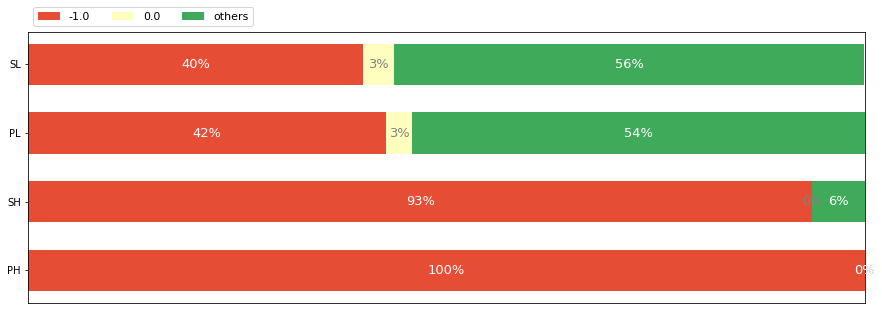

In [14]:
aspect_count = geo_table("Aspect")
cols = [x for x in aspect_count.columns if x not in [-1.0, 0.0]]
aspect_count["others"] = aspect_count.apply(lambda x: sum(x[cols]), axis=1)
geo_precentage(aspect_count, [-1.0, 0.0, "others"], path=constant.plot_path+"geoanalysis/geo_precentage_aspect.png")

## Clustering

In [ ]:
# from sklearn.cluster import SpectralClustering
# windmills_SL_geo = windmill_SL[["Slope", "Aspect", "Roughness"]]
# clustering = SpectralClustering(n_clusters=5,
#         assign_labels="discretize",
#         random_state=0).fit(windmills_SL_geo)
# clus = pd.DataFrame(clustering.labels_, columns=['cls'])
# print(clus.groupby(['cls'])['cls'].count())

In [ ]:
windmills_SH_geo

In [ ]:
windmills_PL_geo = windmill_PL[["Slope", "Aspect", "Roughness"]]
clustering = SpectralClustering(n_clusters=5,
        assign_labels="discretize",
        random_state=0).fit(windmills_PL_geo)
clus = pd.DataFrame(clustering.labels_, columns=['cls'])
print(clus.groupby(['cls'])['cls'].count())

In [ ]:
windmills_PH_geo = windmill_PH[["Slope", "Aspect", "Roughness"]]
windmills_PH_geo

# A simulation of wind speed interpolation with various roughness length

Wind Speed 10m: 5 m/s  
Roughness range: \[0.000001, 0.0003, 0.0005, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6\]  
Interpolated height range: \[0,100\] m

In [15]:
from tools import pow_law, rn_exponent

In [16]:
ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws10_path)

In [91]:
get_ws_h_emrn = lambda h, rn : round(pow_law(ws_ass10, 10, h, rn_exponent(rn)), 5)
get_ws_h_smrn = lambda h, rn : round(pow_law(ws_ass10, 10, h, rn), 5)

In [18]:
np.unique(windmills["Roughness"])

array([1.e-06, 3.e-04, 5.e-04, 5.e-03, 3.e-02, 5.e-02, 1.e-01, 3.e-01,
       5.e-01, 6.e-01])

In [135]:
ws_ass10 = 5
rn_range = [0.000001, 0.0003, 0.0005, 0.005, 0.03, 0.05, 0.1, 0.3, 0.5, 0.6]
h_range = np.linspace(0.1,100,201)

In [136]:
ls_emrn = pd.DataFrame([], columns=h_range, index = rn_range)
ls_smrn = pd.DataFrame([], columns=h_range, index = rn_range)
# ls_comrn = pd.DataFrame([], columns=h_range, index = rn_range)

In [137]:
for rn in rn_range:
    for h in h_range:
        ls_emrn.loc[rn][h] = get_ws_h_emrn(h, rn) 
        ls_smrn.loc[rn][h] = get_ws_h_smrn(h, rn)
        # ls_comrn.loc[rn][h] = get_ws_h_rn(h, rn) if rn >= 0.001 else get_ws_h_smrn(h, rn)

In [138]:
ls_emrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,1.65566,2.54472,2.94313,3.22004,3.43719,3.61796,3.77395,3.91184,4.03586,4.14887,...,8.59361,8.60438,8.6151,8.62578,8.63642,8.64702,8.65758,8.66809,8.67857,8.689
0.000300,3.14935,3.76957,4.006,4.15952,4.27461,4.36723,4.44502,4.51224,4.57152,4.62463,...,6.27104,6.27432,6.27759,6.28084,6.28408,6.28731,6.29052,6.29371,6.29689,6.30006
0.000500,3.19205,3.80072,4.03195,4.18188,4.29418,4.38448,4.46028,4.52575,4.58347,4.63516,...,6.22979,6.23296,6.23611,6.23925,6.24237,6.24548,6.24857,6.25165,6.25472,6.25777
0.005000,3.09982,3.73322,3.97566,4.13335,4.25169,4.34701,4.42712,4.49638,4.5575,4.61227,...,6.31994,6.32337,6.32677,6.33016,6.33354,6.3369,6.34025,6.34358,6.34689,6.35019
0.030000,2.73621,3.45916,3.74478,3.93304,4.07556,4.19111,4.28873,4.37351,4.44861,4.51612,...,6.71839,6.72298,6.72755,6.7321,6.73662,6.74113,6.74562,6.75009,6.75454,6.75897
0.050000,2.59778,3.35113,3.65271,3.85257,4.00444,4.1279,4.23243,4.32338,4.40407,4.47671,...,6.8915,6.89661,6.9017,6.90677,6.91182,6.91684,6.92184,6.92682,6.93178,6.93672
0.100000,2.39315,3.18725,3.5118,3.72876,3.89456,4.02994,4.14496,4.24532,4.33459,4.41513,...,7.17421,7.1802,7.18616,7.1921,7.19801,7.2039,7.20976,7.2156,7.22141,7.2272
0.300000,2.04463,2.89497,3.25651,3.50226,3.69215,3.84848,3.98219,4.09951,4.20435,4.29935,...,7.74942,7.75727,7.76509,7.77288,7.78064,7.78836,7.79605,7.80371,7.81134,7.81894
0.500000,1.87875,2.74908,3.12704,3.38624,3.58772,3.75434,3.89735,4.0232,4.13596,4.23837,...,8.07746,8.08643,8.09535,8.10424,8.11309,8.12191,8.13069,8.13943,8.14815,8.15682
0.600000,1.81966,2.69592,3.07949,3.34344,3.54906,3.71938,3.86578,3.99475,4.11043,4.21556,...,8.20494,8.21434,8.2237,8.23303,8.24231,8.25156,8.26077,8.26995,8.27909,8.2882


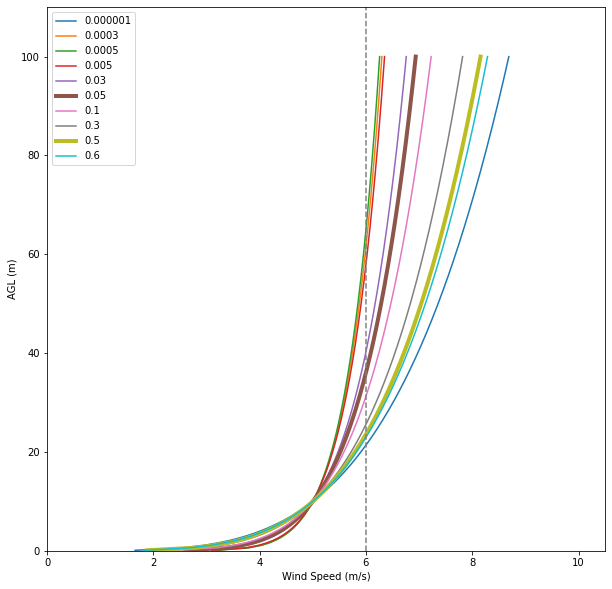

In [139]:
roughness_simulation(ls_emrn, h_range, path=constant.plot_path+"geoanalysis/roughness_simulation_emp.png")

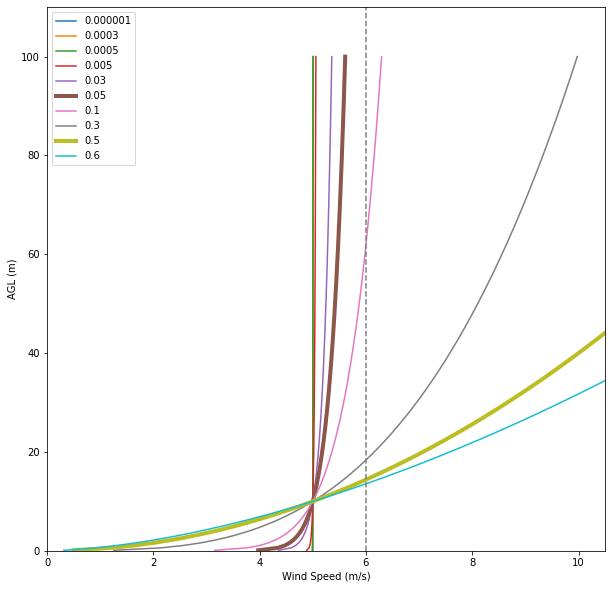

In [140]:
roughness_simulation(ls_smrn, h_range, path=constant.plot_path+"geoanalysis/roughness_simulation_smp.png")

In [141]:
ls_smrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,4.99998,4.99999,4.99999,4.99999,4.99999,4.99999,4.99999,4.99999,5,5,...,5.00001,5.00001,5.00001,5.00001,5.00001,5.00001,5.00001,5.00001,5.00001,5.00001
0.000300,4.9931,4.99578,4.99669,4.99725,4.99766,4.99798,4.99824,4.99847,4.99866,4.99883,...,5.00339,5.00339,5.0034,5.00341,5.00342,5.00342,5.00343,5.00344,5.00345,5.00346
0.000500,4.9885,4.99297,4.99448,4.99542,4.9961,4.99663,4.99707,4.99744,4.99777,4.99806,...,5.00564,5.00566,5.00567,5.00568,5.0057,5.00571,5.00572,5.00573,5.00575,5.00576
0.005000,4.88619,4.93014,4.9451,4.95437,4.96111,4.96641,4.97078,4.9745,4.97774,4.9806,...,5.05673,5.05687,5.057,5.05713,5.05726,5.05739,5.05752,5.05764,5.05777,5.0579
0.030000,4.35482,4.59519,4.67951,4.7324,4.77116,4.80183,4.82723,4.84894,4.86789,4.88472,...,5.35021,5.35105,5.35188,5.35271,5.35353,5.35435,5.35517,5.35598,5.35679,5.3576
0.050000,3.97164,4.3437,4.47734,4.562,4.62445,4.6741,4.71538,4.75077,4.78176,4.80935,...,5.5972,5.59866,5.60012,5.60156,5.603,5.60443,5.60586,5.60728,5.60869,5.61009
0.100000,3.15479,3.77354,4.00931,4.16238,4.27711,4.36944,4.44697,4.51396,4.57305,4.62597,...,6.26574,6.26901,6.27226,6.2755,6.27873,6.28194,6.28513,6.28831,6.29148,6.29463
0.300000,1.25594,2.14935,2.57792,2.88459,3.12976,3.33685,3.51765,3.67904,3.82541,3.95977,...,9.83959,9.855,9.87036,9.88566,9.9009,9.91609,9.93123,9.94631,9.96134,9.97631
0.500000,0.5,1.22423,1.65756,1.99906,2.2902,2.54828,2.78253,2.99854,3.2,3.38951,...,15.4519,15.4923,15.5325,15.5726,15.6127,15.6526,15.6925,15.7322,15.7719,15.8114
0.600000,0.31548,0.92394,1.32913,1.66417,1.95909,2.22691,2.47477,2.70706,2.92675,3.13595,...,19.3635,19.4242,19.4848,19.5452,19.6056,19.6658,19.7259,19.7858,19.8456,19.9054


In [142]:
ls_emrn

,0.1000,0.5995,1.0990,1.5985,2.0980,2.5975,3.0970,3.5965,4.0960,4.5955,...,95.5045,96.0040,96.5035,97.0030,97.5025,98.0020,98.5015,99.0010,99.5005,100.0000
0.000001,1.65566,2.54472,2.94313,3.22004,3.43719,3.61796,3.77395,3.91184,4.03586,4.14887,...,8.59361,8.60438,8.6151,8.62578,8.63642,8.64702,8.65758,8.66809,8.67857,8.689
0.000300,3.14935,3.76957,4.006,4.15952,4.27461,4.36723,4.44502,4.51224,4.57152,4.62463,...,6.27104,6.27432,6.27759,6.28084,6.28408,6.28731,6.29052,6.29371,6.29689,6.30006
0.000500,3.19205,3.80072,4.03195,4.18188,4.29418,4.38448,4.46028,4.52575,4.58347,4.63516,...,6.22979,6.23296,6.23611,6.23925,6.24237,6.24548,6.24857,6.25165,6.25472,6.25777
0.005000,3.09982,3.73322,3.97566,4.13335,4.25169,4.34701,4.42712,4.49638,4.5575,4.61227,...,6.31994,6.32337,6.32677,6.33016,6.33354,6.3369,6.34025,6.34358,6.34689,6.35019
0.030000,2.73621,3.45916,3.74478,3.93304,4.07556,4.19111,4.28873,4.37351,4.44861,4.51612,...,6.71839,6.72298,6.72755,6.7321,6.73662,6.74113,6.74562,6.75009,6.75454,6.75897
0.050000,2.59778,3.35113,3.65271,3.85257,4.00444,4.1279,4.23243,4.32338,4.40407,4.47671,...,6.8915,6.89661,6.9017,6.90677,6.91182,6.91684,6.92184,6.92682,6.93178,6.93672
0.100000,2.39315,3.18725,3.5118,3.72876,3.89456,4.02994,4.14496,4.24532,4.33459,4.41513,...,7.17421,7.1802,7.18616,7.1921,7.19801,7.2039,7.20976,7.2156,7.22141,7.2272
0.300000,2.04463,2.89497,3.25651,3.50226,3.69215,3.84848,3.98219,4.09951,4.20435,4.29935,...,7.74942,7.75727,7.76509,7.77288,7.78064,7.78836,7.79605,7.80371,7.81134,7.81894
0.500000,1.87875,2.74908,3.12704,3.38624,3.58772,3.75434,3.89735,4.0232,4.13596,4.23837,...,8.07746,8.08643,8.09535,8.10424,8.11309,8.12191,8.13069,8.13943,8.14815,8.15682
0.600000,1.81966,2.69592,3.07949,3.34344,3.54906,3.71938,3.86578,3.99475,4.11043,4.21556,...,8.20494,8.21434,8.2237,8.23303,8.24231,8.25156,8.26077,8.26995,8.27909,8.2882


In [143]:
ws10 = pd.read_parquet(constant.ws10_path)
ws100 = pd.read_parquet(constant.ws100_path)
def ws100_evaluation(df, ws_ass10, rn_range):
    ws100_rn = pd.DataFrame(columns=rn_range,index=['real','interp'])
    for rn in rn_range:
        if rn == 0.001:
            continue
        grid = windmills[windmills["Roughness"] == rn].head(1)["grid"].tolist()[0]
        index = ws10[ws10[grid] == ws_ass10].index[0]
        ws100_rn.loc['real'][rn] = ws100[[grid]].iloc[index][0]

    ws100_rn.loc["interp"] = df[100].T
    ws100_rn = ws100_rn.T
    ws100_rn["AE"] = abs(ws100_rn["interp"] -  ws100_rn["real"])
    return ws100_rn

In [158]:
ls_smrn_evl = ws100_evaluation(ls_smrn, ws_ass10, rn_range)
ls_smrn_evl

,real,interp,AE
0.000001,7.3,5.00001,2.29999
0.000300,6.5,5.00346,1.49654
0.000500,7.6,5.00576,2.59424
0.005000,8.7,5.0579,3.6421
0.030000,6.4,5.3576,1.0424
0.050000,5.7,5.61009,0.08991
0.100000,5.6,6.29463,0.69463
0.300000,8,9.97631,1.97631
0.500000,7.5,15.8114,8.31139
0.600000,10.3,19.9054,9.60536


In [159]:
ls_emrn_evl = ws100_evaluation(ls_emrn, ws_ass10, rn_range)
ls_emrn_evl

,real,interp,AE
0.000001,7.3,8.689,1.389
0.000300,6.5,6.30006,0.19994
0.000500,7.6,6.25777,1.34223
0.005000,8.7,6.35019,2.34981
0.030000,6.4,6.75897,0.35897
0.050000,5.7,6.93672,1.23672
0.100000,5.6,7.2272,1.6272
0.300000,8,7.81894,0.18106
0.500000,7.5,8.15682,0.65682
0.600000,10.3,8.2882,2.0118
